In [7]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import json
import glob
from tqdm import tqdm

import xgboost as xgb #BDT

In [8]:
glob.glob("hadds/extraJetsBDT_Run2/*.root")

['hadds/extraJetsBDT_Run2/tt1l.root',
 'hadds/extraJetsBDT_Run2/tth.root',
 'hadds/extraJetsBDT_Run2/ssww.root',
 'hadds/extraJetsBDT_Run2/wz.root',
 'hadds/extraJetsBDT_Run2/tt2l.root',
 'hadds/extraJetsBDT_Run2/ttw.root',
 'hadds/extraJetsBDT_Run2/ttz.root',
 'hadds/extraJetsBDT_Run2/vbshww.root']

In [9]:
df = []
for sample in glob.glob("hadds/extraJetsBDT_Run2/*.root"):
    # Retrieve TTree
    f = uproot.open(sample)
    tree = f.get("variable")
    temp_df = tree.pandas.df(branches="MVA_*", flatten=True)
    temp_df["MVA_sample_name"] = sample.split(".root")[0].split("/")[-1]
    df.append(temp_df)

df = pd.concat(df)
# Remove "MVA" prefix from column names
df.columns = df.columns.str.split("MVA_").str.get(1)
# Make a preliminary cut on Mjj
outside_df = df[np.abs(df.extra_jet_pair_M - 80.379) > 30].copy()
df = df[np.abs(df.extra_jet_pair_M - 80.379) < 30]

In [10]:
with open("features.json", "r") as fin:
    features = json.load(fin)
    
# BDT
bdt = pickle.load(open("bdt.pkl", "r")) # BDT model

In [11]:
df["bdt"] = bdt.predict(xgb.DMatrix(df[features]))
outside_df["bdt"] = bdt.predict(xgb.DMatrix(outside_df[features]))

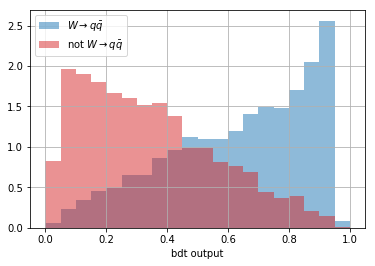

In [12]:
fig, axes = plt.subplots();

df[df.extra_jet_pair_is_match].bdt.hist(
    ax=axes,
    bins=np.linspace(0,1,21),
    alpha=0.5,
    color="C0",
    density=True,
    label=r"$W\rightarrow q\bar{q}$"
);
df[~df.extra_jet_pair_is_match].bdt.hist(
    bins=np.linspace(0,1,21), 
    stacked=True, 
    alpha=0.5,
    color="C3",
    label=r"not $W\rightarrow q\bar{q}$",
    density=True
);

plt.legend();
plt.xlabel("bdt output");

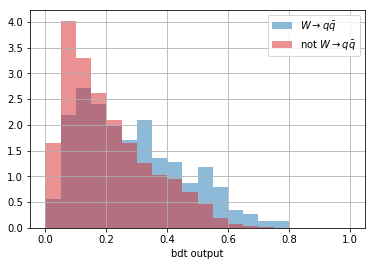

In [13]:
fig, axes = plt.subplots();

outside_df[outside_df.extra_jet_pair_is_match].bdt.hist(
    ax=axes,
    bins=np.linspace(0,1,21),
    alpha=0.5,
    color="C0",
    density=True,
    label=r"$W\rightarrow q\bar{q}$"
);
outside_df[~outside_df.extra_jet_pair_is_match].bdt.hist(
    bins=np.linspace(0,1,21), 
    stacked=True, 
    alpha=0.5,
    color="C3",
    label=r"not $W\rightarrow q\bar{q}$",
    density=True
);

plt.legend();
plt.xlabel("bdt output");

In [ ]:
ttw_df = df[(df.sample_name == "ttw")].copy()
ttz_df = df[(df.sample_name == "ttz")].copy()
vbshww_df = df[df.sample_name == "vbshww"].copy()

In [7]:
event_value_counts = df.event.value_counts()

single_pair_events = event_value_counts[event_value_counts == 1].index

In [8]:
df.index.get_level_values(0).unique()

Int64Index([   0,    3,    5,    8,    1,    4,   12,   13,   16,   17,
            ...
            8871, 8872, 8874, 8875, 8877, 8878, 8879, 8880, 8882, 8884],
           dtype='int64', name=u'entry', length=7683)

In [9]:
ttw_df.index.get_level_values(0).nunique()

5349

In [10]:
ttw_df.event.nunique()

5348

In [11]:
from tqdm import tqdm

def filter_for_max_bdt_pairs(df):
    to_drop_dfs = []
    df_entries = df.index.get_level_values(0)
    for entry in tqdm(df_entries.unique()):
        entry_df = df[df_entries == entry]
        this_drop_df = entry_df[entry_df.bdt != entry_df.bdt.max()]
        to_drop_dfs.append(this_drop_df)

    to_drop_dfs = pd.concat(to_drop_dfs)
    return df.drop(to_drop_dfs.index)

In [12]:
filtered_ttw_df = filter_for_max_bdt_pairs(ttw_df)

100%|██████████| 5349/5349 [00:09<00:00, 585.83it/s]


In [13]:
filtered_ttz_df = filter_for_max_bdt_pairs(ttz_df)

100%|██████████| 5743/5743 [00:10<00:00, 553.58it/s]


In [14]:
filtered_vbshww_df = filter_for_max_bdt_pairs(vbshww_df)

100%|██████████| 202/202 [00:00<00:00, 553.16it/s]


In [15]:
vbshww_df.head(17)

extra_jet_pair_dR  extra_jet_pair_M  extra_jet_pair_ld_pt  \
entry subentry                                                              
0     4                  1.580346         87.729897              76.50000   
2     1                  3.144242         98.022675              53.59375   
      2                  2.888929        100.221375              53.59375   
      3                  3.009225         68.722519              33.96875   
      4                  2.559333         65.793304              33.96875   
5     2                  1.381498         89.408195             112.25000   
      5                  2.579185         76.614960              37.40625   
6     0                  3.020681        105.899055              39.31250   
7     4                  1.175189         65.635590              82.25000   
9     0                  2.030625         88.653725              42.43750   
10    0                  1.368815        103.660332              71.62500   
      3                  1.661699         95.417374              69.43750   
      5                  1.704712         62.014488              35.50000   
15    2                  0.840032         60.775520             118.12500   
16    1                  1.283337         83.066467             110.50000   
      2                  1.553789         88.547150             110.50000   
      4                  2.538764         96.162376              48.03125   

                extra_jet_pair_ld_eta  extra_jet_pair_ld_phi  \
entry subentry                                                 
0     4                     -0.933350              -1.262939   
2     1                      2.115234               0.518188   
      2                      2.115234               0.518188   
      3                      1.172119               0.565918   
      4                      1.172119               0.565918   
5     2                     -0.101410               1.551270   
      5                      2.272461              -0.155853   
6     0                      1.075439              -1.701904   
7     4                      0.290710              -0.688477   
9     0                      1.751465              -0.827393   
10    0                      1.300049              -0.915771   
      3                      0.183441              -0.124039   
      5                     -1.472412               0.015221   
15    2                      0.846436              -0.689819   
16    1                      0.793823              -0.763428   
      2                      0.793823              -0.763428   
      4                      2.178711               2.829590   

                extra_jet_pair_ld_qg_disc  extra_jet_pair_tr_pt  \
entry subentry                                                    
0     4                          0.257568             36.093750   
2     1                          0.206665             33.125000   
      2                          0.206665             32.281250   
      3                          0.034241             33.125000   
      4                          0.034241             32.281250   
5     2                          0.193115             31.375000   
      5                          0.212891             31.375000   
6     0                          0.048218             37.406250   
7     4                          0.559570             31.187500   
9     0                          0.206055             30.656250   
10    0                          0.230957             69.437500   
      3                          0.024277             35.500000   
      5                          0.622070             30.265625   
15    2                          0.011978             38.281250   
16    1                          0.003124             35.281250   
      2                          0.003124             31.968750   
      4                          0.917480             31.968750   

                extra_jet_pair_tr_eta  extra_jet_pair_tr_phi 

In [16]:
filtered_vbshww_df.head()

,,extra_jet_pair_dR,extra_jet_pair_M,extra_jet_pair_ld_pt,extra_jet_pair_ld_eta,extra_jet_pair_ld_phi,extra_jet_pair_ld_qg_disc,extra_jet_pair_tr_pt,extra_jet_pair_tr_eta,extra_jet_pair_tr_phi,extra_jet_pair_tr_qg_disc,run,event,lumi,sample_name,bdt
entry,subentry,,,,,,,,,,,,,,,
0,4,1.580346,87.729897,76.50000,-0.933350,-1.262939,0.257568,36.09375,-2.132324,-2.292480,0.035828,10,36,1,vbshww,0.330297
2,4,2.559333,65.793304,33.96875,1.172119,0.565918,0.034241,32.28125,0.821167,3.101074,0.800293,104,10,1,vbshww,0.425137
5,2,1.381498,89.408195,112.25000,-0.101410,1.551270,0.193115,31.37500,1.138428,2.160645,0.625000,105,68,2,vbshww,0.500935
6,0,3.020681,105.899055,39.31250,1.075439,-1.701904,0.048218,37.40625,2.762207,0.803955,-1.000000,106,6,1,vbshww,0.019061
7,4,1.175189,65.635590,82.25000,0.290710,-0.688477,0.559570,31.18750,-0.829834,-0.334290,0.449463,108,62,2,vbshww,0.557439


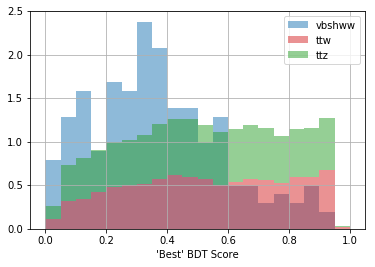

In [28]:
fig, axes = plt.subplots();

filtered_vbshww_df.bdt.hist(
    ax=axes,
    bins=np.linspace(0,1,21),
    alpha=0.5,
    color="C0",
    density=True,
    label="vbshww"
);

# pd.concat([filtered_ttw_df, filtered_ttz_df]).bdt.hist(
#     ax=axes,
#     bins=np.linspace(0,1,21),
#     alpha=0.5,
#     color="C3",
#     density=True,
#     label="ttw+ttz"
# );

plt.hist(
    [filtered_ttw_df["bdt"], filtered_ttz_df["bdt"]],
    bins=np.linspace(0,1,21), 
    stacked=True, 
    alpha=0.5,
    color=["C3","C2"],
    label=["ttw", "ttz"],
    density=True
)

plt.legend();
plt.xlabel("'Best' BDT Score");